<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/5-support-vector-machines/03_svm_fundamental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##SVM Fundamental

A Support Vector Machine (SVM) is a powerful and versatile Machine Learning
model, capable of performing linear or nonlinear classification, regression, and even
outlier detection.

SVMs are particularly
well suited for classification of complex small- or medium-sized datasets.

This notebook explains how SVMs make predictions and how their training algorithms
work, starting with linear SVM classifiers.



##Setup

In [14]:
# Common imports
import numpy as np
import os

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn import datasets
from sklearn.datasets import make_moons

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [15]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

##Decision Function and Predictions

The linear SVM classifier model predicts the class of a new instance $x$ by simply computing
the decision function $w^⊺ x + b = w_1 x_1 + ⋯ + w_n x_n + b$. If the result is positive,
the predicted class $\hat y$ is the positive class (1), and otherwise it is the negative class (0).

$
\hat{y} = \begin{cases}
 0 & \text{if } \mathbf{w}^T \mathbf{x} + b < 0, \\
 1 & \text{if } \mathbf{w}^T \mathbf{x} + b \geq 0
\end{cases}
$



In [ ]:
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)
svm_clf2.fit(X, y)

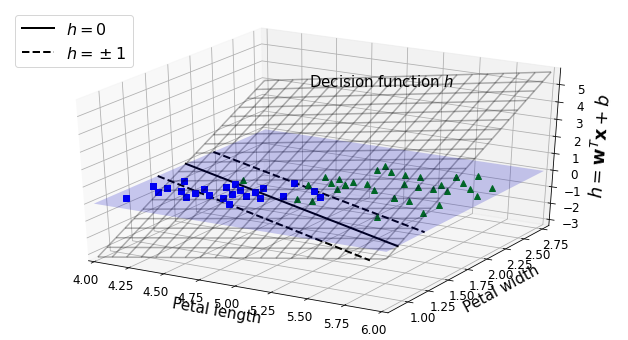

In [17]:
def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=15)
    ax.set_xlabel(r"Petal length", fontsize=15)
    ax.set_ylabel(r"Petal width", fontsize=15)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

plt.show()

The decision boundary is the set of points where the decision function is
equal to 0: it is the intersection of two planes, which is a straight line (represented by
the thick solid line).

The dashed lines represent the points where the decision function is equal to 1 or –1:
they are parallel and at equal distance to the decision boundary, and they form a margin
around it. Training a linear SVM classifier means finding the values of w and b
that make this margin as wide as possible while avoiding margin violations (hard
margin) or limiting them (soft margin).

##Training Objective

Consider the slope of the decision function: it is equal to the norm of the weight vector,
$∥ w ∥$. If we divide this slope by 2, the points where the decision function is equal
to ±1 are going to be twice as far away from the decision boundary. 

In other words,
dividing the slope by 2 will multiply the margin by 2.

The smaller the weight vector $w$, the larger the
margin.

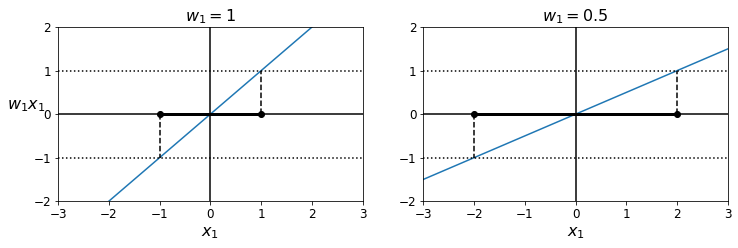

In [18]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

plt.figure(figsize=(12, 3.2))
plt.subplot(121)
plot_2D_decision_function(1, 0)
plt.subplot(122)
plot_2D_decision_function(0.5, 0, ylabel=False)

plt.show()

So we want to minimize $∥ w ∥$ to get a large margin. If we also want to avoid any
margin violations (hard margin), then we need the decision function to be greater
than 1 for all positive training instances and lower than –1 for negative training
instances.

$
\begin{split}
&\underset{\mathbf{w}, b}{\operatorname{minimize}}\quad{\frac{1}{2}\mathbf{w}^T \mathbf{w}} \\
&\text{subject to} \quad t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b) \ge 1 \quad \text{for } i = 1, 2, \dots, m
\end{split}
$

We can therefore express the hard margin linear SVM classifier objective as the constrained
optimization problem.

In [19]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris-Virginica

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X, y)
svm_clf.predict([[5.3, 1.3]])

array([1.])

##Hinge loss

The function $max(0, 1 – t)$ is called the hinge loss function.

It is equal to 0 when $t ≥ 1$. Its derivative (slope) is equal to –1 if $t < 1$ and 0 if $t > 1$. 

It is
not differentiable at $t = 1$, but just like for Lasso Regression, you can still use Gradient Descent using any subderivative at $t = 1$ (i.e.,
any value between –1 and 0).

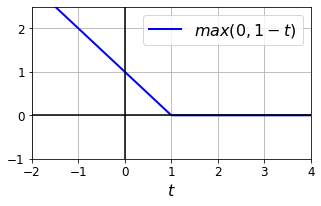

In [20]:
t = np.linspace(-2, 4, 200)
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)

plt.show()